# Machine Learning Trading Strategy Design_Version 2

## Improvement compared with Version 1
1. I added several more technical indicators, including Momentum, MACD, RSI and Percentage Price Oscillator to enrich the features of the learning model.
2. Also tried other model, i.e., random forest, to learn from our features and generate trading signals.
3. Extended the backtest results and enable our strategy hold different numbers of stocks.
4. Conducted large numbers of result visulizations and comparisons based on different performance metrics.

## Summary
### Conclusion
1. The added technical indicators worsen the performance of learning models, which indicates the effectiveness of the original features of R and V series proposed by myself in Version 1.
2. The random forest model generates worse performance, which manifests that, with limited number of features, the more complicated model is prone to overfitting, and logistic regression is simple but useful.
3. For the returns of different time horizons, the model can get the best prediction (with highest precision and recall scores) for the probability of obtaining a return over 0.5% by holding stocks for 10 days.
4. For the proposed strategy, the maximum holding stock number of 10 or 15 can get good performance over various metrics, including return, sharp ratio, max drawdown and so on. If the maximum holding stock number is smaller than 10, i.e., 1,3 and 5, the max drawdown will be dramatically degraded; and if the maximum holding stock number is larger than 15, i.e., 20,30 and 50, the return will be lowered while the max drawdown will not be improved.
5. Till now, the performance of the proposed strategy is good and can achieve a sharp ratio over 2, while the performance of max drawdown can be further improved.

### Future Directions
1. More effective features can be proposed to facilitate the learning of different models, such as some risk related features to improve the max drawdown performance.
2. More kinds of machine learning techniques can be tried, such as lightGBM, xgboost, svm, mlp, LSTM and so on, and more opimization of hyperparameters has to be taken into account with methods such as cross validation.
3. Consider and deal with more practical issues in the backtest process. As an example, stocks may not be traded due to suspension, limit up or limit down.  
4. Consider to apply such a similar machine learning method to other stock markets, such as US and CH markets.
5. Machine learning methods with decision-making process such as reinforcement learning techniques can be further explored to design trading strategies.


In [1]:
import pandas as pd
import numpy as np
import talib

In [2]:
df_raw = pd.read_csv('data.csv')
df_raw['date'] = pd.to_datetime(df_raw.date) 
df_raw.describe()

,last,volume
count,451113.000000,4.511130e+05
mean,2751.772257,3.469636e+06
std,3988.203423,8.373189e+06
min,63.000000,0.000000e+00
25%,1099.145800,7.861000e+05
50%,1901.445100,1.614400e+06
75%,3169.704000,3.595100e+06
max,109550.000000,7.289341e+08


## Generate features and returns of different time horizons
### The features of R and V series is proposed by myself and the key idea is to describe the short term and long term return performance and volume change of each stock to help the model to learning potential alpha. 

In [3]:
%%time
ticker_list = df_raw['ticker'].unique().tolist()
df_list = []
for ticker in ticker_list:
    df_ticker = df_raw[df_raw['ticker']==ticker]
    df_ticker.set_index('date')
    #  Momentum, MACD - Moving Average Convergence/Divergence, RSI - Relative Strength Index, Percentage Price Oscillator
    df_ticker["MOM"] = talib.MOM(df_ticker["last"], timeperiod=10).div(100)
    df_ticker["dmacd"],df_ticker["macdsignal"],df_ticker["macdhist"] = talib.MACD(df_ticker["last"], fastperiod=12, slowperiod=26, signalperiod=9)
    df_ticker["RSI"] = talib.RSI(df_ticker["last"], timeperiod=14).div(100)
    df_ticker["PPO"] = talib.PPO(df_ticker["last"], fastperiod=12, slowperiod=26, matype=0)

    for d in [-1,-2,-3,-5,-10,-20,-30,-60,-120,-360,-720]: 
        exec('df_ticker["R_{}"]=df_ticker["last"].pct_change(periods={})'.format(-d,-d))
        exec('df_ticker["V_{}"]=df_ticker["volume"].pct_change(periods={})'.format(-d,-d))
    for d in [1,3,5,10]: 
        exec('df_ticker["Y_{}"]=df_ticker["R_{}"].shift(periods={})'.format(d,d,-d))
    df_list.append(df_ticker.set_index('date'))
    
df = pd.concat(df_list)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()

/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

CPU times: user 12.7 s, sys: 355 ms, total: 13 s
Wall time: 13.2 s


## Generate labels of different time horizons and returns 
### Since the commission rate is usually >=0.2%, I consider to predict at least r > 0.5% to ensure the profit

In [4]:
for d in [1,3,5,10]:
    exec('y{} = df["Y_{}"].tolist()'.format(d,d))
    for r in [0.005, 0.01, 0.03]:
        exec('df["Y_{}_{}"] = [1 if yy > {} else 0 for yy in y{}]'.format(d,r,r,d))

## Divide Train and Test Sets
### Set a gap of more than 10 days between the end of the train set and the start of the test set to avoid potential information leak

In [5]:
df_train = df[df.index <= '2018-12-15']
df_test = df[df.index > '2018-12-31']

df_train.to_csv('train.csv')
df_test.to_csv('test.csv')

## Build machine learning model to generate trading signals

In [6]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score, precision_recall_fscore_support, classification_report

/anaconda3/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Random Forest Classifier
#### The precision and recall scores are not as good as the following Logistic Regression

In [7]:
feature_list = ["MOM","dmacd","macdsignal","macdhist","RSI","PPO"]

for d in [-1,-2,-3,-5,-10,-20,-30,-60,-120,-360,-720]:
    feature_list.append('R_{}'.format(-d))
    feature_list.append('V_{}'.format(-d))

x_train = np.array(df_train[feature_list])
x_test = np.array(df_test[feature_list])

for d in [1,3,5,10]:
    for r in [0.005, 0.01, 0.03]:
        exec('clf = RandomForestClassifier(random_state=0,class_weight="balanced").fit(x_train, df_train["Y_{}_{}"])'.format(d,r))
        predict = clf.predict(x_test)
        predict_score = clf.predict_proba(x_test)
        #print(predict_score[:,1])
        exec('df_test["predict_Y_{}_{}"] = predict_score[:,1]'.format(d,r))
        exec('accuracy = accuracy_score(predict,df_test["Y_{}_{}"])'.format(d,r))
        exec('precision = precision_score(predict,df_test["Y_{}_{}"])'.format(d,r))
        exec('recall = recall_score(predict,df_test["Y_{}_{}"])'.format(d,r))
        print('#################################')
        print(f"For the Y_{d}_{r} label with Random Forest model, performance metrics:")
        print(f"accuracy: {accuracy}")
        print(f"precision: {precision}")
        print(f"recall: {recall}")
        print('#################################')
#df_test.to_csv('test.csv')


/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#################################
For the Y_1_0.005 label with Random Forest model, performance metrics:
accuracy: 0.5959259128219644
precision: 0.1393308514926612
recall: 0.3850085178875639
#################################


/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#################################
For the Y_1_0.01 label with Random Forest model, performance metrics:
accuracy: 0.7189269034814605
precision: 0.04599181193872161
recall: 0.3258479532163743
#################################


/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#################################
For the Y_1_0.03 label with Random Forest model, performance metrics:
accuracy: 0.931308378148882
precision: 0.0014263485477178422
recall: 0.14473684210526316
#################################


/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#################################
For the Y_3_0.005 label with Random Forest model, performance metrics:
accuracy: 0.5281984149448061
precision: 0.2578096658470716
recall: 0.43649764553333786
#################################


/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#################################
For the Y_3_0.01 label with Random Forest model, performance metrics:
accuracy: 0.6011180300028305
precision: 0.1447811447811448
recall: 0.3869889431730522
#################################


/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#################################
For the Y_3_0.03 label with Random Forest model, performance metrics:
accuracy: 0.8258739031984149
precision: 0.01750524109014675
recall: 0.2621664050235479
#################################


/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#################################
For the Y_5_0.005 label with Random Forest model, performance metrics:
accuracy: 0.5141876592131334
precision: 0.30980152204673217
recall: 0.462517841849843
#################################


/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#################################
For the Y_5_0.01 label with Random Forest model, performance metrics:
accuracy: 0.5585992782337956
precision: 0.2070056791086834
recall: 0.4175958721413267
#################################


/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#################################
For the Y_5_0.03 label with Random Forest model, performance metrics:
accuracy: 0.7603576988395132
precision: 0.047023878409134745
recall: 0.33786031042128606
#################################


/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#################################
For the Y_10_0.005 label with Random Forest model, performance metrics:
accuracy: 0.49846978488536653
precision: 0.3510284866049339
recall: 0.4985818629050476
#################################


/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#################################
For the Y_10_0.01 label with Random Forest model, performance metrics:
accuracy: 0.5158417067647891
precision: 0.2684032580298141
recall: 0.45622857142857143
#################################
#################################
For the Y_10_0.03 label with Random Forest model, performance metrics:
accuracy: 0.6606460515142938
precision: 0.09748855279589289
recall: 0.37544084642513625
#################################


/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Logistic Regression
#### The precision and recall scores are better than the Random Forest results above

In [8]:
#feature_list = ["MOM","dmacd","macdsignal","macdhist","RSI","PPO"]
feature_list = []
for d in [-1,-2,-3,-5,-10,-20,-30,-60,-120,-360,-720]:
    feature_list.append('R_{}'.format(-d))
    feature_list.append('V_{}'.format(-d))

x_train = np.array(df_train[feature_list])
x_test = np.array(df_test[feature_list])

for d in [1,3,5,10]:
    for r in [0.005, 0.01, 0.03]:
        exec('clf = LogisticRegression(random_state=0,class_weight="balanced").fit(x_train, df_train["Y_{}_{}"])'.format(d,r))
        predict = clf.predict(x_test)
        predict_score = clf.predict_proba(x_test)
        #print(predict_score[:,1])
        exec('df_test["predict_Y_{}_{}"] = predict_score[:,1]'.format(d,r))
        exec('accuracy = accuracy_score(predict,df_test["Y_{}_{}"])'.format(d,r))
        exec('precision = precision_score(predict,df_test["Y_{}_{}"])'.format(d,r))
        exec('recall = recall_score(predict,df_test["Y_{}_{}"])'.format(d,r))
        print('#################################')
        print(f"For the Y_{d}_{r} label with Logistic Regression model, performance metrics:")
        print(f"accuracy: {accuracy}")
        print(f"precision: {precision}")
        print(f"recall: {recall}")
        print('#################################')
df_test.to_csv('test.csv')

/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#################################
For the Y_1_0.005 label with Logistic Regression model, performance metrics:
accuracy: 0.518910982168129
precision: 0.5047779384914519
recall: 0.3885167813406822
#################################
#################################
For the Y_1_0.01 label with Logistic Regression model, performance metrics:
accuracy: 0.5581570195301444
precision: 0.4919109878499736
recall: 0.30121504963305906
#################################
#################################
For the Y_1_0.03 label with Logistic Regression model, performance metrics:
accuracy: 0.6703757429946221
precision: 0.4962396265560166
recall: 0.10285422489787142
#################################
#################################
For the Y_3_0.005 label with Logistic Regression model, performance metrics:
accuracy: 0.5042633739031984
precision: 0.5539320407916482
recall: 0.44765301801361607
#################################
#################################
For the Y_3_0.01 label with Logistic Regre

### Logistic Regression model with Y_10_0.005 (i.e., predict the probability of obtaining a return over 0.5% by holding an stock for 10 days) obtains the best model performance (both precision and recall) and we will design the strategy for backtesting accordingly 
accuracy: 0.5131350834984433
precision: 0.5923163921679508
recall: 0.5117955138874044



## Strategy Descriptions for Backtesting
#### Buy 1 to 50 stocks with the highest prediction scores
#### Hold 10 days and re-select the stocks to buy every 10 days
#### COMMISSION RATE is set to 0.1% for buy and sell, respectively
#### n is the maximum holding number of stocks

In [9]:
COMMISSION_RATE = 0.001
df = pd.read_csv('test.csv')

In [10]:
%%time
date_test = df['date'].unique().tolist()
date_list = []
for n in [1,3,5,10,15,20,30,50]:
    exec(f'r_list_{n} = []')
    exec(f'stock_list_{n} = []')

for i in range(0,len(date_test),10):
    date = date_test[i]
    df1 = df[df['date']==date]
    date_list.append(date)
    for n in [1,3,5,10,15,20,30,50]:
        df2 = df1.sort_values(['predict_Y_10_0.005'], ascending=False).head(n)
        ticker = df2['ticker'].tolist()
        if len(df2) == n:
            r = df2['Y_10'].mean() - 2*COMMISSION_RATE
        elif len(df2) < n:
            r = (len(df2)/n)*(df2['Y_10'].mean()- 2*COMMISSION_RATE)
        else:
            pass
        
        exec(f'r_list_{n}.append(r)')
        exec(f'stock_list_{n}.append(ticker)')

CPU times: user 1.58 s, sys: 134 ms, total: 1.72 s
Wall time: 1.74 s


In [11]:
result_list = []
for n in [1,3,5,10,15,20,30,50]:
    exec(f'result_list.append("hold_stock_{n}")')
    exec(f'result_list.append("real_return_{n}")')
    exec(f'result_list.append("Cumulative_return_{n}")')

result = pd.DataFrame(columns = ['date']+result_list)
result['date'] = date_list
for n in [1,3,5,10,15,20,30,50]:
    exec(f'result["hold_stock_{n}"] = stock_list_{n}')
    exec(f'result["real_return_{n}"] = [0]+r_list_{n}[:-1]')
    exec(f'result["Cumulative_return_{n}"] = result["real_return_{n}"].add(1).cumprod().fillna(1)')
result.to_csv('backtest_result.csv')

In [12]:
# Visualize results
import pyfolio as pf
import matplotlib.pyplot as plt

result = pd.read_csv('backtest_result.csv')
result['date'] = pd.to_datetime(result.date) 
#result['date'] = result['date'].tz_localize('UTC')
result.set_index('date', inplace=True)
for n in [1,3,5,10,15,20,30,50]:
    exec(f'perf_stats_{n} = pf.timeseries.perf_stats(result["real_return_{n}"])')
    exec(f'perf_stats_{n}.to_csv("perf_stats_{n}.csv")')

print('#################################')
print(f"perf_stats_1: \n {perf_stats_1}")
print('#################################')
print(f"perf_stats_3: \n {perf_stats_3}")
print('#################################')
print(f"perf_stats_5: \n {perf_stats_5}")
print('#################################')
print(f"perf_stats_10: \n {perf_stats_10}")
print('#################################')
print(f"perf_stats_15: \n {perf_stats_15}")
print('#################################')
print(f"perf_stats_20: \n {perf_stats_20}")
print('#################################')
print(f"perf_stats_30: \n {perf_stats_30}")
print('#################################')
print(f"perf_stats_50: \n {perf_stats_50}")
print('#################################')

/anaconda3/anaconda3/lib/python3.6/site-packages/empyrical/utils.py:32: UserWarning: Unable to import pandas_datareader. Suppressing import error and continuing. All data reading functionality will raise errors; but has been deprecated and will be removed in a later version.
  warnings.warn(msg)
/anaconda3/anaconda3/lib/python3.6/site-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


#################################
perf_stats_1: 
 Annual return          1.738533
Cumulative returns     0.235998
Annual volatility      1.430000
Sharpe ratio           1.404271
Calmar ratio           3.337579
Stability              0.457716
Max drawdown          -0.520896
Omega ratio            1.272085
Sortino ratio          2.146410
Skew                   0.139527
Kurtosis               0.625061
Tail ratio             0.800717
Daily value at risk   -0.172194
dtype: float64
#################################
perf_stats_3: 
 Annual return          2.944318
Cumulative returns     0.334576
Annual volatility      1.085841
Sharpe ratio           1.826688
Calmar ratio           6.278470
Stability              0.176986
Max drawdown          -0.468955
Omega ratio            1.378432
Sortino ratio          2.549300
Skew                  -0.968160
Kurtosis               3.099200
Tail ratio             1.005745
Daily value at risk   -0.128932
dtype: float64
#################################
perf

<Figure size 432x288 with 0 Axes>

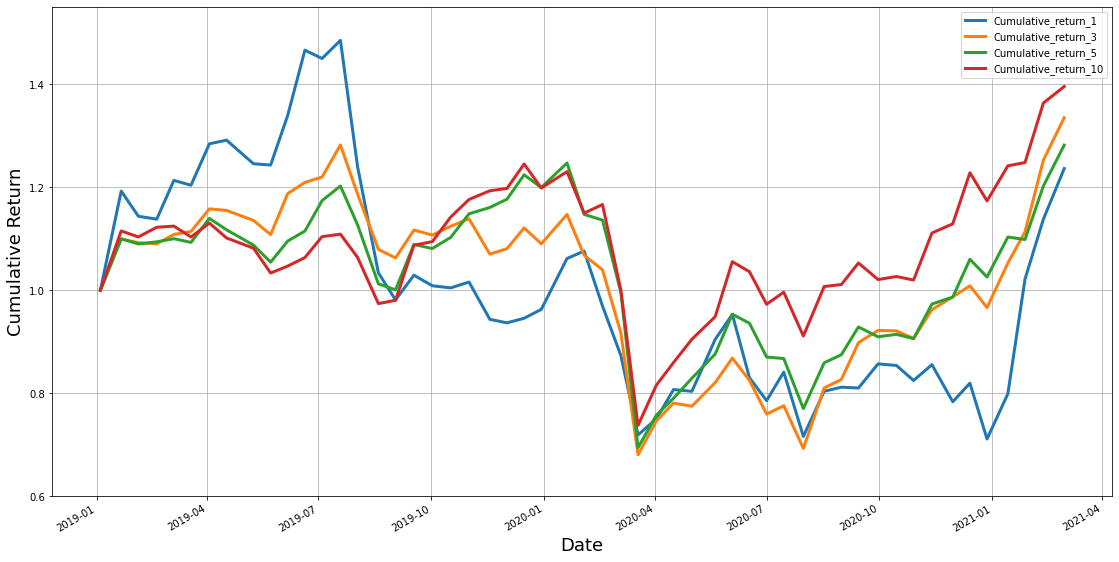

<Figure size 432x288 with 0 Axes>

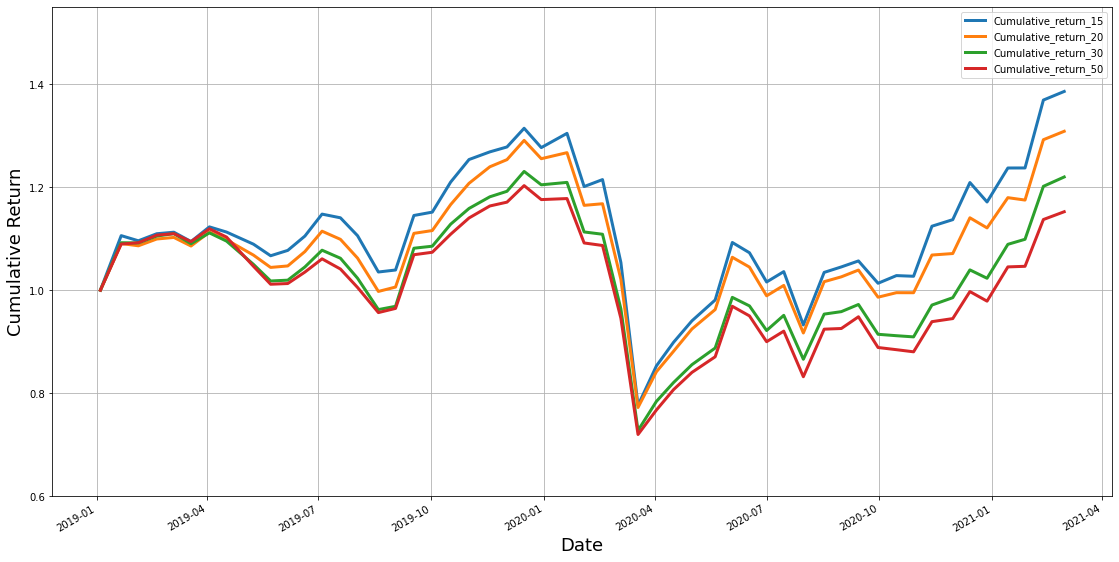

In [13]:
result_cum1 = result[["Cumulative_return_1","Cumulative_return_3","Cumulative_return_5","Cumulative_return_10"]] 
result_cum2 = result[["Cumulative_return_15","Cumulative_return_20","Cumulative_return_30","Cumulative_return_50"]] 

plt.figure()
result_cum1.plot(figsize=(19,10),grid=True,linewidth=3)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Cumulative Return', fontsize=18)
plt.ylim(0.6,1.55)

plt.savefig('cum_sum_result_1-10.jpg')

plt.figure()
result_cum2.plot(figsize=(19,10),grid=True,linewidth=3)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Cumulative Return', fontsize=18)
plt.ylim(0.6,1.55)

plt.savefig('cum_sum_result_15-50.jpg')
